    ResNet-FC-1000: Ridimensiona l'immagine a 224x224; collega un "hook" all'output del livello "fc" dell'architettura pre-addestrata ResNet per ottenere un tensore di dimensione 1000.  

In [46]:
# Standard library
# Standard library
import os
from collections import defaultdict, Counter

# Scientific/numeric
import numpy as np

# Image processing
import cv2
from PIL import Image

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and torchvision
import torch
from torchvision import models
from torchvision.models import ResNet50_Weights

# Machine Learning (scikit-learn)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support
)
from sklearn.metrics.pairwise import (
    pairwise_distances,
    cosine_distances,
    euclidean_distances, 
    manhattan_distances
)
from scipy.spatial.distance import (
    correlation, 
    mahalanobis
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import MDS

# Advanced dimensionality reduction
import umap



  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3586 sha256=0d498a26748ce88a6d5cf8b72cc34b10d0025853b6d127d064901a1d9255e382
  Stored in directory: c:\users\martj\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\82\d8\73\e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap
Note: you may need to restart the kernel to use updated packages.


Setup

In [47]:
def crop_to_brain(img):
    """Ritaglia l'area informativa (cervello) da un'immagine."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return img[y:y+h, x:x+w]
    plt.imshow(img)
    plt.show()
    return img  # fallback

In [48]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()


# Task 1-2

Implementa un programma che estrae e memorizza i descrittori di feature per tutte le immagini nel set di dati

In [49]:
def extract_fc_features(image_path, model, preprocess, device):
    """
    Estrae:
    - feature del layer fully connected (fc) di ResNet50
    - immagine ritagliata (cropped_img)
    - tensore preprocessato (img_tensor)
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {image_path}")
        return None, None, None

    cropped_img = crop_to_brain(img)
    pil_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(pil_img).unsqueeze(0).to(device)

    fc_output = []

    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    if fc_output:
        fc_vec = fc_output[0].squeeze(0).cpu().numpy()
        return fc_vec, cropped_img, img_tensor
    else:
        print(f"[ERRORE] Nessun output FC per {image_path}")
        return None, None, None

Elaborazione Batch e Salvataggio Feature in .npz

In [50]:
def process_and_save_features(base_folder, subfolders, output_file):
    """
    Estrae le feature FC da immagini in più cartelle e salva in un file .npz.
    """
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features, _, _ = extract_fc_features(img_path, model, preprocess, device)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

In [8]:
# Parametri cartelle e output
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "resnetfc_part1")
process_and_save_features("Part2", subfolders, "resnetfc_part2")

[INFO] Elaboro cartella: brain_glioma


KeyboardInterrupt: 

In [51]:
#funzione di creazione dei file
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "resnetfc_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "resnetfc_part2.npz")

### Grad-CAM (Gradient-weighted Class Activation Mapping)

#### Cos'è il Grad-CAM?

Grad-CAM è una tecnica di visualizzazione per le **reti neurali convoluzionali (CNN)** che permette di capire **quali regioni dell'immagine** hanno influenzato maggiormente la predizione del modello.

È particolarmente utile per:
- applicazioni mediche: localizzazione di tumori o anomalie in immagini diagnostiche.

---

#### Come funziona

Grad-CAM utilizza:

1. Le **attivazioni** di un layer convoluzionale profondo (es. `layer4` in ResNet).
2. I **gradienti dei logit** (output prima del softmax) rispetto a quelle attivazioni.

##### Passaggi principali:

1. **Esegui forward pass** per ottenere le predizioni del modello.
2. **Esegui backward pass** sulla classe target per ottenere i gradienti rispetto al layer scelto.
3. Calcola i **pesi (αᵢ)** facendo la media spaziale dei gradienti per ogni canale.
4. Combina i pesi con le attivazioni convoluzionali per ottenere la **mappa Grad-CAM**:
   \[
   \text{Grad-CAM}(x, y) = \text{ReLU} \left( \sum_i \alpha_i \cdot A_i(x, y) \right)
   \]
5. Applica una **colormap** e sovrapponila all'immagine originale.

---

#### Interpretazione della Heatmap

**Rosso / Giallo**: Aree di **alta importanza** per la decisione del modello.
**Blu / Nero**: Aree **poco o per nulla considerate** dal modello.


In [52]:
def generate_gradcam_with_legend(image_path, model, preprocess, device, target_layer="layer4"):
    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata: {image_path}")
        return

    img = crop_to_brain(img)
    orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(orig_img)
    input_tensor = preprocess(pil_img).unsqueeze(0).to(device)

    features, gradients = [], []

    def forward_hook(m, i, o): features.append(o)
    def backward_hook(m, gi, go): gradients.append(go[0])

    layer = dict([*model.named_modules()])[target_layer]
    fh = layer.register_forward_hook(forward_hook)
    bh = layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    top_idx = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, top_idx].backward()

    grads = gradients[0]
    fmap = features[0]
    weights_ = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights_ * fmap).sum(dim=1).squeeze(0)
    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    cam_np = cam.detach().cpu().numpy()

    heatmap = cv2.resize(cam_np, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(orig_img, 0.5, heatmap_color, 0.5, 0)

    fh.remove(); bh.remove()

    # --- Plot ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(orig_img)
    ax[0].set_title("Immagine ritagliata")
    ax[0].axis("off")

    ax[1].imshow(superimposed)
    ax[1].set_title(f"Grad‑CAM – classe idx {top_idx}")
    ax[1].axis("off")

    # Legenda
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.set_label('Importanza (attivazione Grad‑CAM)')

    plt.tight_layout()
    plt.show()

In [53]:
def generate_gradcam_with_legend1(image_path, model, preprocess, device, target_layer="layer4"):
    # Usa extract_fc_features_from_image per preprocessing e feature extraction
    fc_vec, cropped_img, img_tensor = extract_fc_features(image_path, model, preprocess, device)

    if fc_vec is None or cropped_img is None or img_tensor is None:
        print("[ERRORE] Estrazione FC o preprocess fallita.")
        return

    # Converti immagine in RGB per visualizzazione
    orig_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

    features, gradients = [], []

    def forward_hook(m, i, o): features.append(o)
    def backward_hook(m, gi, go): gradients.append(go[0])

    # Hook su layer target
    layer = dict([*model.named_modules()])[target_layer]
    fh = layer.register_forward_hook(forward_hook)
    bh = layer.register_backward_hook(backward_hook)

    # Forward e backward
    output = model(img_tensor)
    top_idx = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, top_idx].backward()

    grads = gradients[0]
    fmap = features[0]
    weights_ = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights_ * fmap).sum(dim=1).squeeze(0)
    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    cam_np = cam.detach().cpu().numpy()

    heatmap = cv2.resize(cam_np, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(orig_img, 0.5, heatmap_color, 0.5, 0)

    fh.remove(); bh.remove()

    # --- Plot ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(orig_img)
    ax[0].set_title("Immagine ritagliata")
    ax[0].axis("off")

    ax[1].imshow(superimposed)
    ax[1].set_title(f"Grad‑CAM – classe idx {top_idx}")
    ax[1].axis("off")

    # Legenda
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.set_label('Importanza (attivazione Grad‑CAM)')

    plt.tight_layout()
    plt.show()

C:\Users\martj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


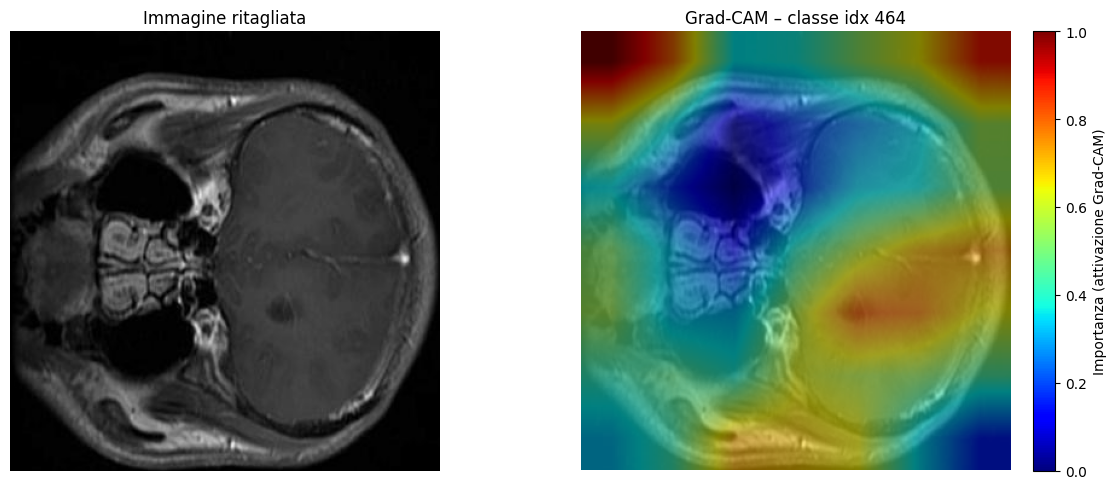

In [54]:
generate_gradcam_with_legend1(
    "Part1/brain_glioma/brain_glioma_0017.jpg",
    model, preprocess, device
)

In [13]:
def visualize_layer4_from_fc(image_path, model, preprocess, device, n_maps=6):
    fc_vec, cropped_img, img_tensor = extract_fc_features(image_path, model, preprocess, device)
    

    if fc_vec is None or cropped_img is None or img_tensor is None:
        return

    activations = []

    def hook_fn(module, input, output):
        activations.append(output.squeeze(0).detach().cpu())  # [C, H, W]

    handle = model.layer4.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(img_tensor)
    handle.remove()

    fmap = activations[0]
    n_maps = min(n_maps, fmap.shape[0])

    fig, axs = plt.subplots(1, n_maps, figsize=(4 * n_maps, 4))
    for i in range(n_maps):
        axs[i].imshow(fmap[i], cmap='viridis')
        axs[i].set_title(f"Map {i}")
        axs[i].axis('off')

    plt.suptitle("Mappe di attivazione – layer4")
    plt.tight_layout()
    plt.show()

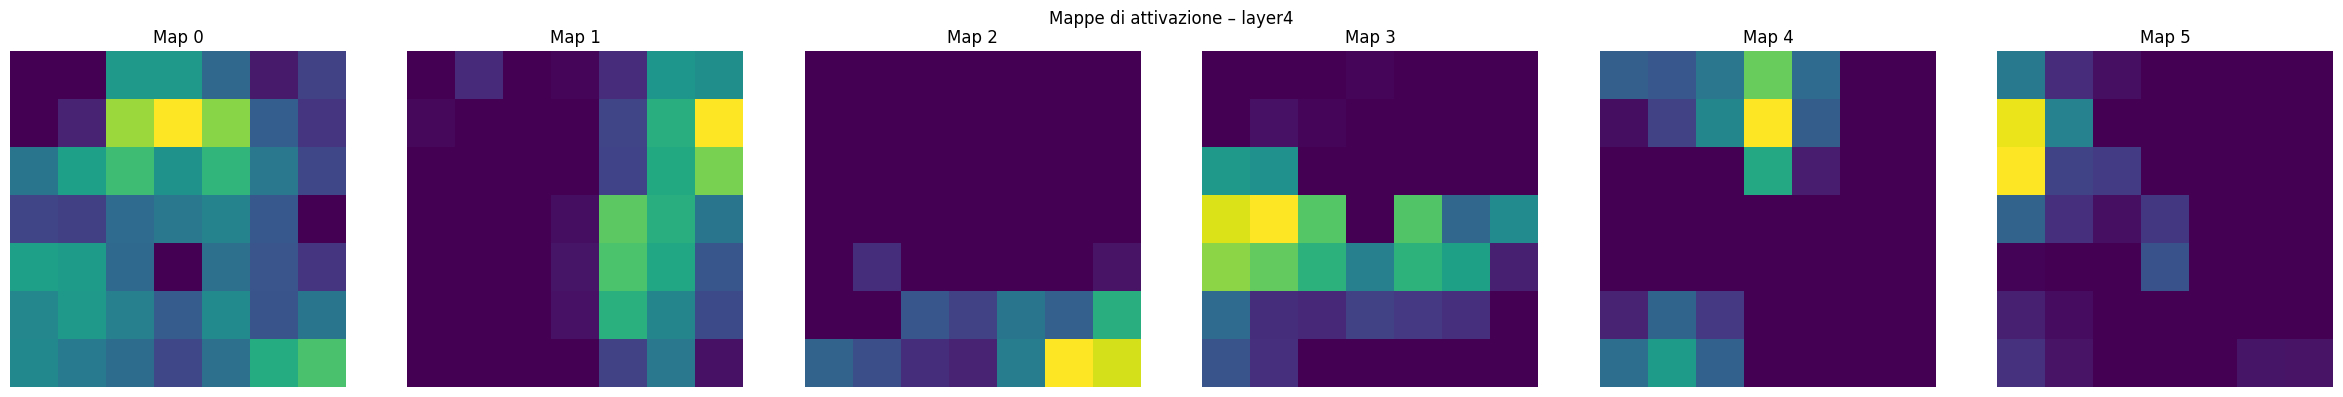

In [14]:
visualize_layer4_from_fc(
    "Part1/brain_glioma/brain_glioma_0017.jpg",
    model, preprocess, device,
    n_maps=6
)

# Task 3

 Implementa un programma che, dato il nome di un file immagine e un valore "k", restituisce e visualizza le k immagini più simili in base a ciascun modello visivo - selezionerai l'appropriata misura di distanza/similarità per ciascun modello di feature.  Per ogni corrispondenza, elenca anche il corrispondente punteggio di distanza/similarità. 

  *Retrieval: Immagini più Simili (distanza coseno)*
 

In [15]:
def find_k_similar_cosine(img_path, k):
    """
    Trova le k immagini più simili rispetto a una query, usando la distanza coseno.
    """
    query_feature, _, _ = extract_fc_features(img_path, model, preprocess, device) 
    if query_feature is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = cosine_distances(feat_matrix_part1, query_feature).flatten()

    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {top_k_scores[rank]:.4f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.4f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg
1. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 0.0981
2. brain_glioma_0144.jpg | Classe: brain_glioma | Distanza: 0.1032
3. brain_glioma_0536.jpg | Classe: brain_glioma | Distanza: 0.1052
4. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 0.1090
5. brain_glioma_0507.jpg | Classe: brain_glioma | Distanza: 0.1112


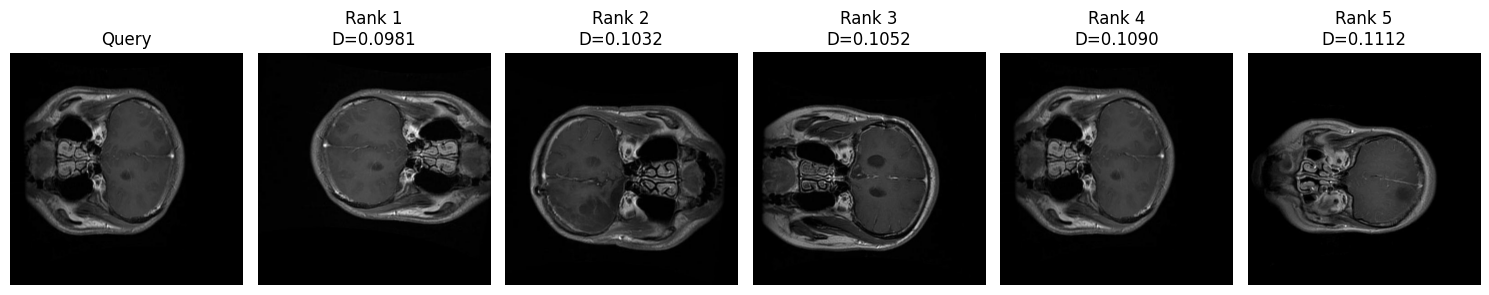

In [16]:

# Test su immagine di query
query_img = "Part1/brain_glioma/brain_glioma_0017.jpg"
find_k_similar_cosine(query_img, k=5)

In [18]:
def find_k_similar_with_metric(img_path, k, metric="cosine"):
    query_feature, _, _ = extract_fc_features(img_path, model, preprocess, device)
    if query_feature is None:
        print("[ERRORE] Estrazione feature fallita.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    if metric == "cosine":
        distances = cosine_distances(feat_matrix_part1, query_feature).flatten()
    elif metric == "euclidean":
        distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    elif metric == "manhattan":
        distances = manhattan_distances(feat_matrix_part1, query_feature).flatten()
    elif metric == "correlation":
        distances = np.array([correlation(query_feature[0], v) for v in feat_matrix_part1])
    elif metric == "mahalanobis":
        VI = np.linalg.inv(np.cov(feat_matrix_part1.T))
        distances = np.array([mahalanobis(query_feature[0], v, VI) for v in feat_matrix_part1])
    else:
        raise ValueError(f"[ERRORE] Metrica '{metric}' non supportata.")

    # top-k più simili
    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    # stampa risultati
    print(f"\nTop {k} immagini più simili a: {img_path} usando metrica '{metric}'")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {top_k_scores[rank]:.4f}")

    # visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(16, 4))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.4f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

        # Istogramma delle distanze
    plt.figure(figsize=(8, 4))
    sns.histplot(distances, bins=30, kde=True)
    plt.title(f"Distribuzione delle distanze - {metric}")
    plt.xlabel("Distanza")
    plt.ylabel("Frequenza")
    plt.grid(True)
    plt.show()


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg usando metrica 'cosine'
1. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 0.0981
2. brain_glioma_0144.jpg | Classe: brain_glioma | Distanza: 0.1032
3. brain_glioma_0536.jpg | Classe: brain_glioma | Distanza: 0.1052
4. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 0.1090
5. brain_glioma_0507.jpg | Classe: brain_glioma | Distanza: 0.1112


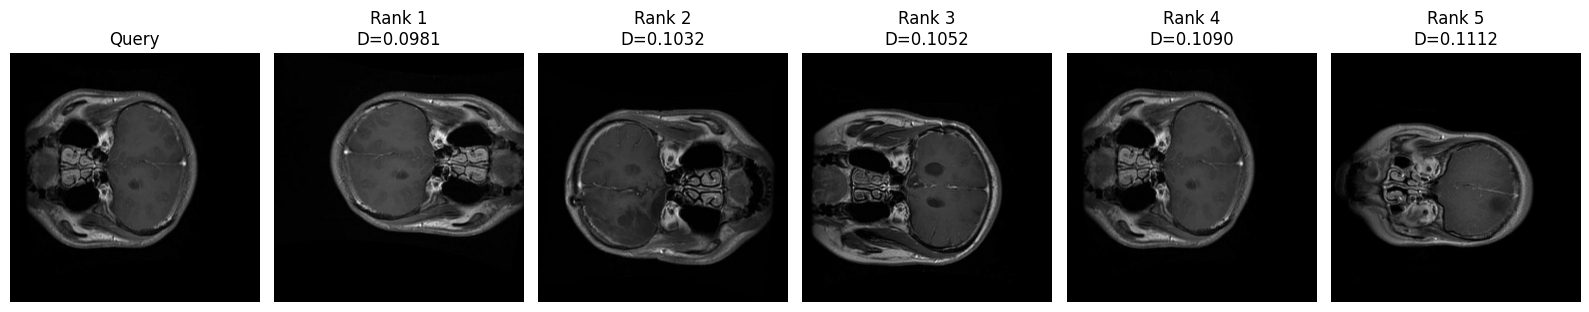

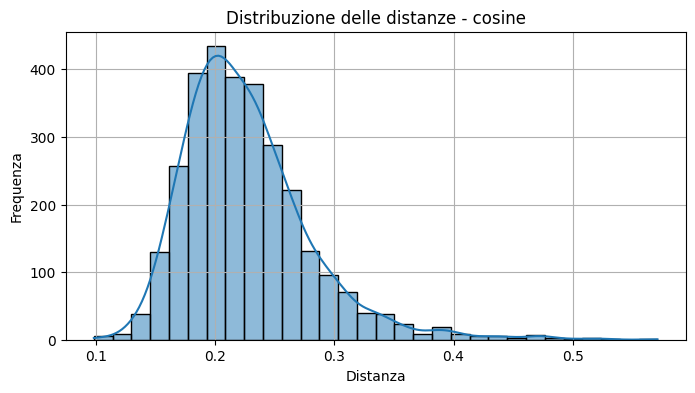


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg usando metrica 'euclidean'
1. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 37.9059
2. brain_glioma_0144.jpg | Classe: brain_glioma | Distanza: 39.1898
3. brain_glioma_0536.jpg | Classe: brain_glioma | Distanza: 39.6548
4. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 40.1084
5. brain_glioma_0507.jpg | Classe: brain_glioma | Distanza: 40.7462


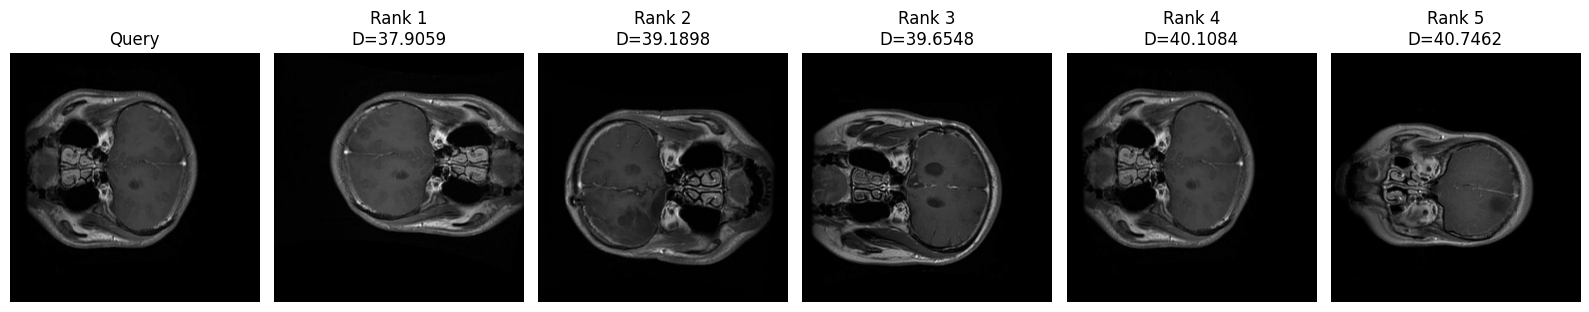

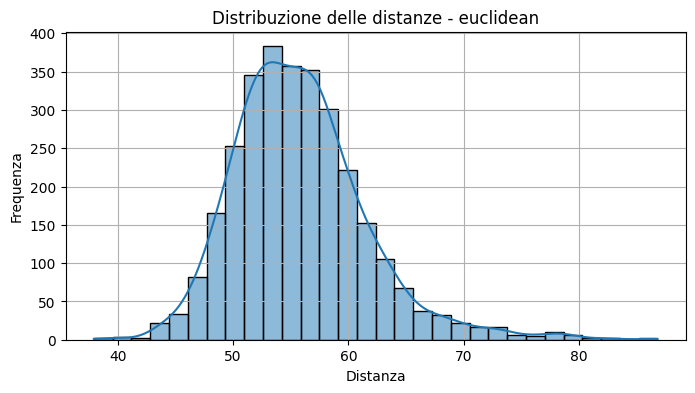


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg usando metrica 'mahalanobis'
1. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 57.5365
2. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 58.5179
3. brain_menin_0154.jpg | Classe: brain_menin | Distanza: 59.1384
4. brain_glioma_0294.jpg | Classe: brain_glioma | Distanza: 59.3423
5. brain_glioma_0593.jpg | Classe: brain_glioma | Distanza: 59.4139


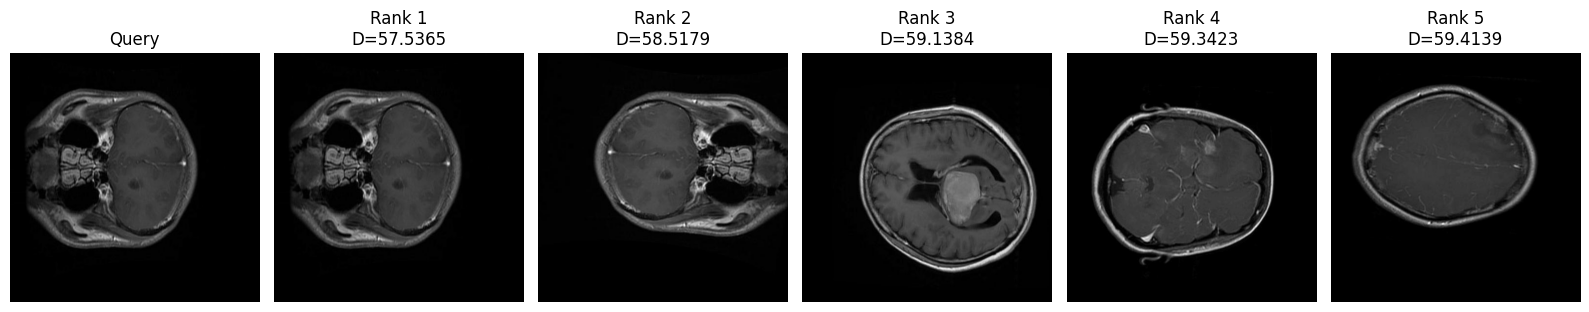

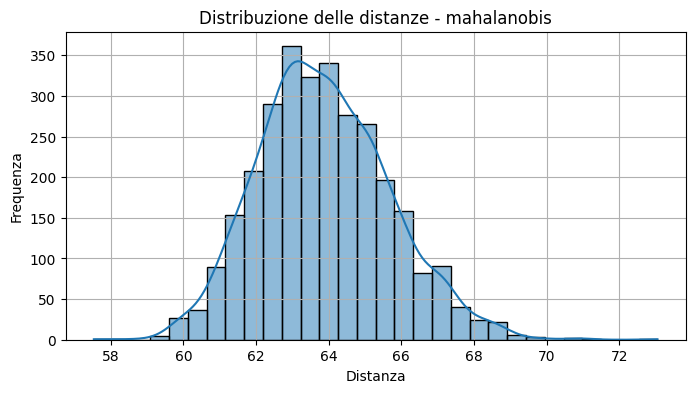


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg usando metrica 'correlation'
1. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 0.0981
2. brain_glioma_0144.jpg | Classe: brain_glioma | Distanza: 0.1032
3. brain_glioma_0536.jpg | Classe: brain_glioma | Distanza: 0.1052
4. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 0.1090
5. brain_glioma_0507.jpg | Classe: brain_glioma | Distanza: 0.1112


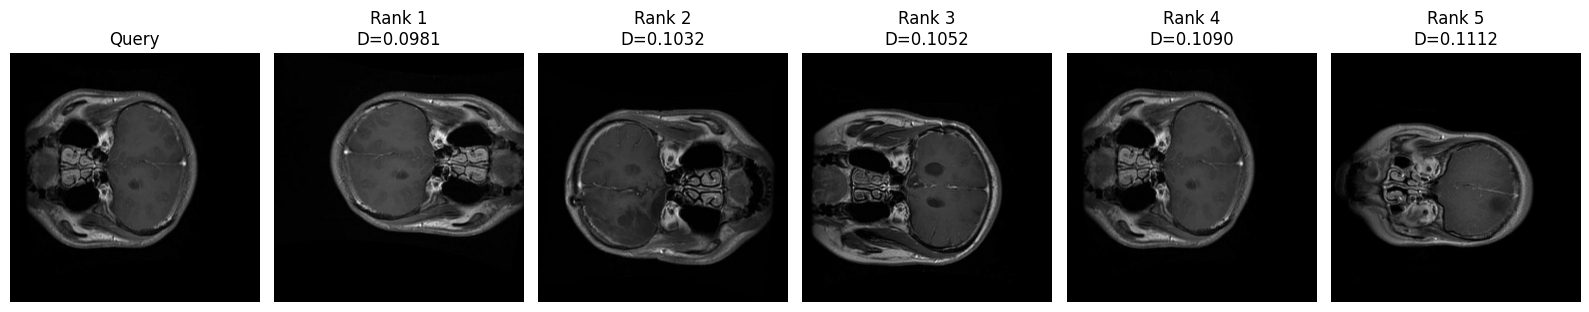

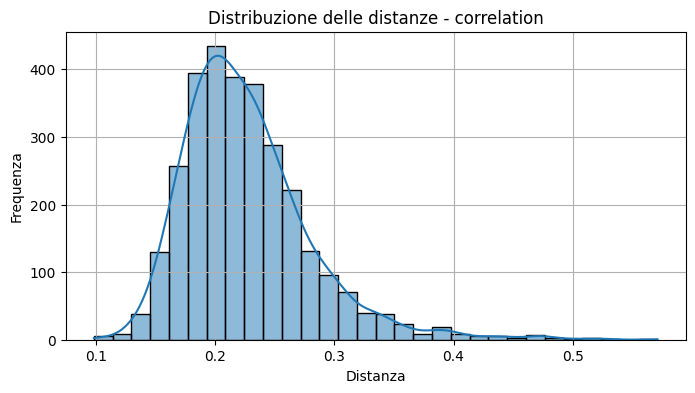


Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0017.jpg usando metrica 'manhattan'
1. brain_glioma_0963.jpg | Classe: brain_glioma | Distanza: 946.9688
2. brain_glioma_0144.jpg | Classe: brain_glioma | Distanza: 958.2606
3. brain_glioma_0536.jpg | Classe: brain_glioma | Distanza: 984.1480
4. brain_glioma_0017.jpg | Classe: brain_glioma | Distanza: 996.0668
5. brain_glioma_0507.jpg | Classe: brain_glioma | Distanza: 1019.8567


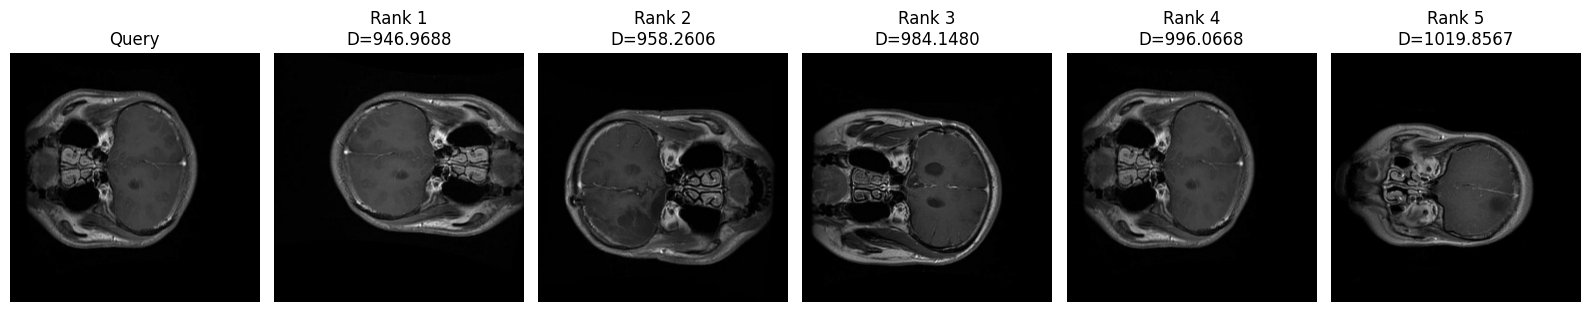

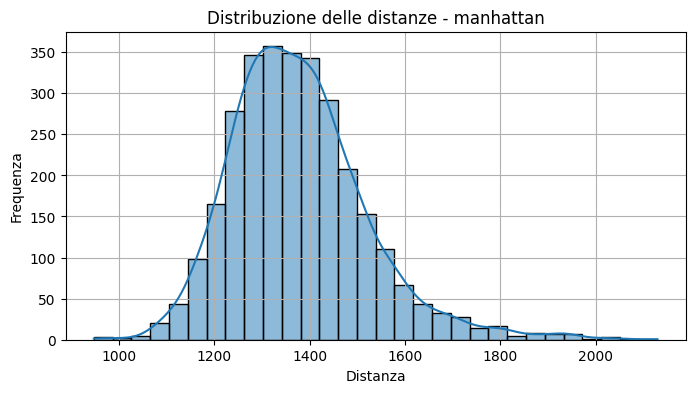

In [19]:
find_k_similar_with_metric("Part1/brain_glioma/brain_glioma_0017.jpg", k=5, metric="cosine")
find_k_similar_with_metric("Part1/brain_glioma/brain_glioma_0017.jpg", k=5, metric="euclidean")
find_k_similar_with_metric("Part1/brain_glioma/brain_glioma_0017.jpg", k=5, metric="mahalanobis")
find_k_similar_with_metric("Part1/brain_glioma/brain_glioma_0017.jpg", k=5, metric="correlation")
find_k_similar_with_metric("Part1/brain_glioma/brain_glioma_0017.jpg", k=5, metric="manhattan")

# Task 4:

 Implementa un programma che, dati (a) un file immagine di query della parte 2, (b) uno spazio di feature selezionato dall'utente e (c) un numero intero positivo k (k<=2), identifica ed elenca le k etichette di corrispondenza più probabili, insieme ai loro punteggi, nello spazio di feature selezionato.    

In [20]:
def task4_predict_labels_resnetfc(query_img_path, k, extractor_fn, features, labels, metric="euclidean"):
    """
    Predict top-k labels for query image using ResNet FC features.
    extractor_fn: funzione che prende image_path e restituisce feature numpy array
    features: matrice numpy (N, d)
    labels: array di stringhe (N,)
    metric: "euclidean" o "cosine"
    """
    assert k <= 2, "k deve essere <= 2"
    print(f"\n======== PREDIZIONE PER: {os.path.basename(query_img_path)} ========")

    def compute_metric(query_feat, target_feats, metric):
        query_feat = query_feat.reshape(1, -1)
        if metric == "euclidean":
            # distanza euclidea tra query_feat e tutti target_feats
            return np.linalg.norm(target_feats - query_feat, axis=1)
        elif metric == "cosine":
            # similarità coseno tra query_feat e tutti target_feats
            # sim = (A·B) / (|A||B|), distanza = 1 - sim
            dot_prod = np.dot(target_feats, query_feat.T).flatten()
            norm_feats = np.linalg.norm(target_feats, axis=1)
            norm_query = np.linalg.norm(query_feat)
            cosine_sim = dot_prod / (norm_feats * norm_query + 1e-10)
            cosine_dist = 1 - cosine_sim  # distanza coseno
            return cosine_dist
        else:
            raise ValueError("Metric must be 'euclidean' or 'cosine'")

    def predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        scores = []
        for label in unique_labels:
            class_feats = features[labels == label]
            dists = compute_metric(query_feat, class_feats, metric)
            scores.append(dists.mean())
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:  # cosine distanza: più piccola è meglio
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: distanza media - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score medio: {scores[idx]:.4f}")

    def predict_top_k_labels_prototype(query_img_path, k, features, labels, metric):
        query_feat = extractor_fn(query_img_path)
        if query_feat is None:
            print("[ERRORE] Feature non estratte.")
            return
        unique_labels = np.unique(labels)
        prototypes = []
        for label in unique_labels:
            class_feats = features[labels == label]
            prototypes.append(class_feats.mean(axis=0))
        prototypes = np.vstack(prototypes)
        scores = compute_metric(query_feat, prototypes, metric)
        if metric == "euclidean":
            top_k = np.argsort(scores)[:k]
        else:
            top_k = np.argsort(scores)[:k]
        print(f"\n[STRATEGIA: prototipo di classe - metrica: {metric}]")
        for idx in top_k:
            print(f"Classe: {unique_labels[idx]} | Score: {scores[idx]:.4f}")

    predict_top_k_labels_distance_mean(query_img_path, k, features, labels, metric)
    predict_top_k_labels_prototype(query_img_path, k, features, labels, metric)


Test

In [21]:
query_img = "Part2/brain_menin/brain_menin_1202.jpg"

# --- KNN con distanza Euclidea ---
task4_predict_labels_resnetfc(
    query_img,
    k=2,
    extractor_fn=lambda img: extract_fc_features(img, model, preprocess, device)[0],  # usa solo il primo valore
    features=feat_matrix_part1,
    labels=lbls_part1,
    metric="euclidean"
)

# --- KNN con distanza Coseno ---
task4_predict_labels_resnetfc(
    query_img,
    k=2,
    extractor_fn=lambda img: extract_fc_features(img, model, preprocess, device)[0],  # usa solo il primo valore
    features=feat_matrix_part1,
    labels=lbls_part1,
    metric="cosine"
)



======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: euclidean]
Classe: brain_tumor | Score medio: 40.3131
Classe: brain_menin | Score medio: 44.8140

[STRATEGIA: prototipo di classe - metrica: euclidean]
Classe: brain_tumor | Score: 26.4658
Classe: brain_menin | Score: 29.0586

======== PREDIZIONE PER: brain_menin_1202.jpg ========

[STRATEGIA: distanza media - metrica: cosine]
Classe: brain_tumor | Score medio: 0.1500
Classe: brain_menin | Score medio: 0.2002

[STRATEGIA: prototipo di classe - metrica: cosine]
Classe: brain_tumor | Score: 0.0709
Classe: brain_menin | Score: 0.0867


# Task 5

Implementa un programma che (a) dato uno dei modelli di feature, (b) un valore k specificato dall'utente, (c) una delle tre tecniche di riduzione della dimensionalità (SVD, LDA, k-means) scelte dall'utente, riporta le prime k semantiche latenti estratte nello spazio di feature selezionato.    

-Memorizza le semantiche latenti in un file di output adeguatamente nominato.    

-Elenca le coppie imageID-peso, ordinate in ordine decrescente di pesi.    


In [22]:
def task5_latent_semantics_resnetfc(feature_model_path, technique, k):
    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

# Creazione output
    output_dir = os.path.join("task5_output", "latent_semantics_resnetfc")
    os.makedirs(output_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = os.path.join(output_dir, f"tutti_i_pesi_{method}_{base_name}_k{k}.txt")

    with open(out_file, "w") as f:
        # intestazione opzionale
        header = "ImageID | Class" + "".join([f" | Peso{i+1}" for i in range(k)]) + "\n"
        f.write(header)
        
        # scegli la matrice trasformata giusta in base alla tecnica
        if technique in ["svd", "lda"]:
            latent_matrix = X_transformed  # shape: (n_immagini, k)
        else:  # kmeans: X_transformed è la distanza da ciascun centroide
            latent_matrix = -X_transformed  # invertiamo il segno per coerenza

        for idx, img in enumerate(flname_part1):
            weights = latent_matrix[idx]
            line = f"{img} | {lbls_part1[idx]}" + "".join([f" | {w:.4f}" for w in weights]) + "\n"
            f.write(line)


def plot_latent_space_2d(X_transformed, labels, technique, k):
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


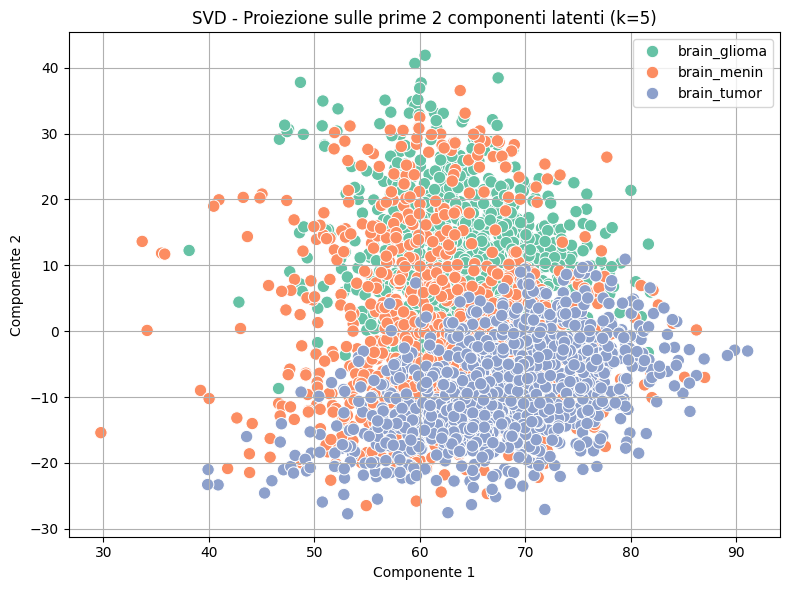

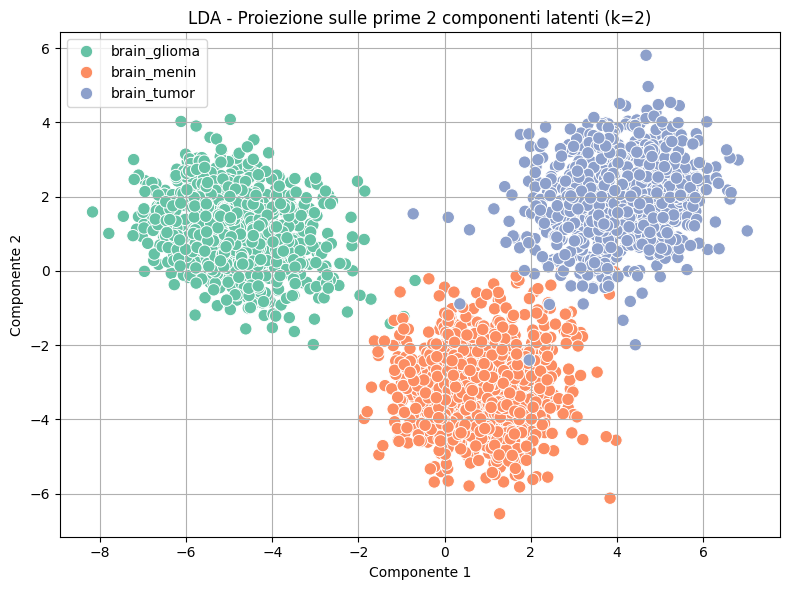

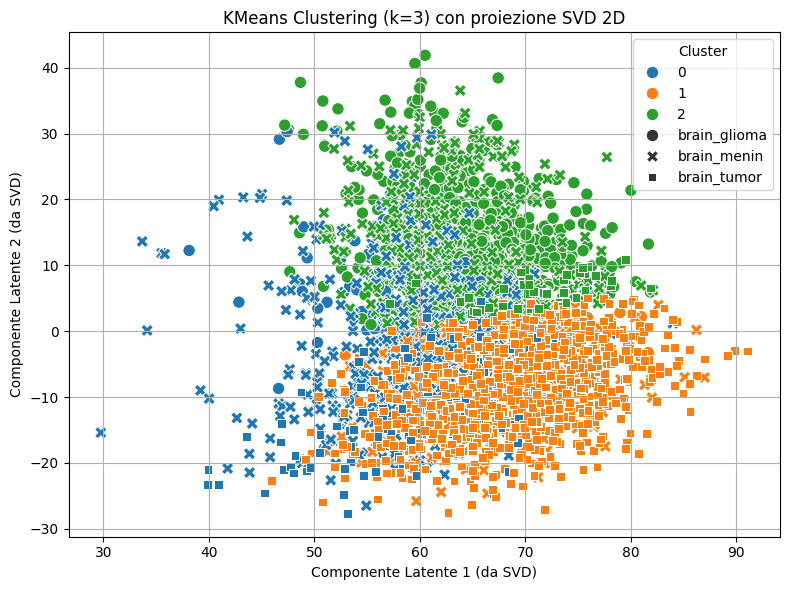

In [23]:
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="svd", k=5)
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="lda", k=2)
task5_latent_semantics_resnetfc("resnetfc_part1.npz", technique="kmeans", k=3)

# Task 6


>Task 6a:

 Implementa un programma che calcola e stampa la "inherent dimensionality" associata alle immagini della parte 1.    


In [24]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    

    if threshold >= 1.0:
        intrinsic_dim = len(cumulative)
    else:
        intrinsic_dim = np.argmax(cumulative >= threshold) + 1
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative



> Task 6b: 

Implementa un programma che calcola e stampa la "dimensionalità intrinseca" (numero di dim indipendenti minime necassari per rappresentare set) associata a ciascuna etichetta univoca delle immagini della parte 1.  

In [25]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


Test

[INFO] Feature matrix shape: (3006, 1000)
[INFO] Dimensione intrinseca stimata: 1000


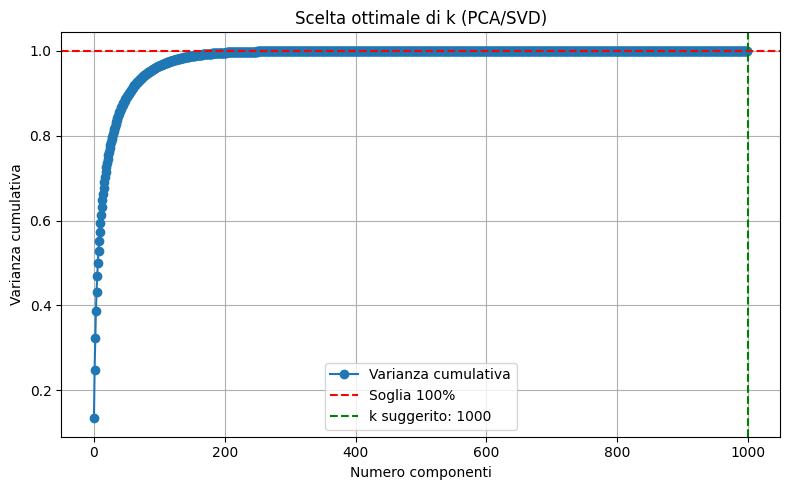

[INFO] k ottimale suggerito (soglia 100%): 1000

 Task 6b – Dimensionalità per etichetta:

[INFO] Etichette uniche trovate: 3
[INFO] Feature matrix shape: (1002, 1000)
[INFO] Dimensione intrinseca stimata: 1000
[INFO] k ottimale suggerito (soglia 100%): 1000
 Label 'brain_glioma' : k = 1000
[INFO] Feature matrix shape: (1002, 1000)
[INFO] Dimensione intrinseca stimata: 1000
[INFO] k ottimale suggerito (soglia 100%): 1000
 Label 'brain_menin' : k = 1000
[INFO] Feature matrix shape: (1002, 1000)
[INFO] Dimensione intrinseca stimata: 1000
[INFO] k ottimale suggerito (soglia 100%): 1000
 Label 'brain_tumor' : k = 1000


In [26]:

estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=1.00, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=1.0)

# Task 7

Implementa un programma che,per ciascuna etichetta univoca l, calcola le corrispondenti k semantiche latenti (a tua scelta) associate alle immagini della parte 1, e
per le immagini della parte 2, prevede le etichette più probabili utilizzando distanze/similarità calcolate sotto le semantiche latenti specifiche dell'etichetta.    
Il sistema dovrebbe anche fornire valori di precision, recall, and F1-score per etichetta, nonché un valore di accuratezza complessiva.   

In [35]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

Test

In [28]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.62, R=0.52, F1=0.57
Class brain_menin: P=0.43, R=0.66, F1=0.52
Class brain_tumor: P=0.53, R=0.34, F1=0.42

Overall Accuracy: 0.51

              precision    recall  f1-score   support

brain_glioma       0.62      0.52      0.57      1002
 brain_menin       0.43      0.66      0.52      1002
 brain_tumor       0.53      0.34      0.42      1002

    accuracy                           0.51      3006
   macro avg       0.53      0.51      0.50      3006
weighted avg       0.53      0.51      0.50      3006



In [33]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_and_plot_confusion(y_true, y_pred, labels_order=None):
    """
    Mostra una confusion matrix e stampa le metriche di classificazione.
    """
    if labels_order is None:
        labels_order = np.unique(np.concatenate([y_true, y_pred]))

    # === Metriche per classe ===
    print("[VALUTAZIONE] Metriche per classe:")
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_order, average=None, zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)

    for label, p, r, f in zip(labels_order, precision, recall, f1):
        print(f"Classe {label}: Precisione={p:.2f}, Recall={r:.2f}, F1-Score={f:.2f}")
    print(f"\nAccuratezza globale: {accuracy:.2f}")
    print(classification_report(y_true, y_pred, labels=labels_order))

    # === Matrice di confusione ===
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix – Task 7")
    plt.tight_layout()
    plt.show()


[VALUTAZIONE] Metriche per classe:
Classe brain_glioma: Precisione=0.62, Recall=0.52, F1-Score=0.57
Classe brain_menin: Precisione=0.43, Recall=0.66, F1-Score=0.52
Classe brain_tumor: Precisione=0.53, Recall=0.35, F1-Score=0.42

Accuratezza globale: 0.51
              precision    recall  f1-score   support

brain_glioma       0.62      0.52      0.57      1002
 brain_menin       0.43      0.66      0.52      1002
 brain_tumor       0.53      0.35      0.42      1002

    accuracy                           0.51      3006
   macro avg       0.53      0.51      0.50      3006
weighted avg       0.53      0.51      0.50      3006



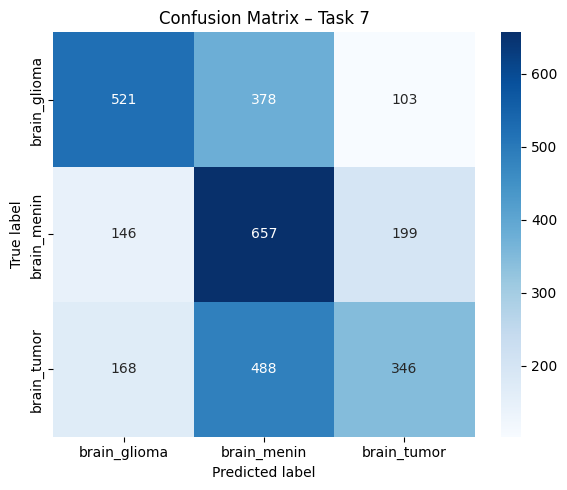

In [37]:
class_models, class_means = compute_latent_semantics_per_class(feat_matrix_part1, lbls_part1, k=10)


y_pred = predict_label(feat_matrix_part2, class_models, class_means)
evaluate_and_plot_confusion(lbls_part2, y_pred)


# Task 8

Implementa un programma che, per ciascuna etichetta univoca l, calcola i corrispondenti c cluster più significativi associati alle immagini della parte 1 (utilizzando l'algoritmo DBScan);
i cluster risultanti devono essere visualizzati sia
come nuvole di punti colorate in modo diverso in uno spazio MDS a 2 dimensioni, sia
come gruppi di miniature di immagini.

In [29]:
#Applichiamo tecniche di dimensionality reduction
def reduce_features(features, method, n_components, random_state=42):
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Metodo di riduzione '{method}' non supportato.")

    return reducer.fit_transform(features)

#Applichiamo una tecnica di riduzione mediante reduce_feature alle features di partenza ottenendo la lista di Feature Latenti
#Applichiamo su insieme di feature latenti StandardScaler per cercare di ottenere migliori cluster tramite DBSCAN

def apply_dbscan_with_pca(features, eps, min_samples, n_components, method):
    print(f"Applicazione di {method} -> Riduzione a {n_components} componenti")
    reduced_features = reduce_features(features, method, n_components=n_components)
    
    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels

#Calcola i 'c' cluster di maggior cardinalità
def top_c_clusters(cluster_labels, c):
    label_counts = Counter(cluster_labels)
    label_counts.pop(-1, None) # rimozione cluster catalogato come rumore (-1)
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i 'c' cluster più frequenti
    most_common = label_counts.most_common(c)
    top = [int(lbl) for lbl, _ in most_common]
    
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


#Applichiamo al risultato di DBSCAN l'algoritmo di MDS
def plot_mds_clusters(features, cluster_labels, top_clusters, metric):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    #Generazione di una nuova matrice basata sul parametro metric (es. 'cosine')
    D = pairwise_distances(features_scaled, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_init=4) 
    Y = mds.fit_transform(D)

    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)
    
    plt.title(f"MDS 2D - Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()

#Genera blocco di immagini trovate per cluster
def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16-25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)
            
            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()

In [30]:
def db_scan_detection(eps, min_samples, n_components, c, method):
    
    base_folder = "Part1" 
    images_full = [os.path.join(base_folder, lbl, fname) for fname, lbl in zip(flname_part1, lbls_part1)]

    # Scorre ogni label di Parte1 ed applico DBSCAN+PCA
    unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

    for lbl in unique_labels:
        print(f"\n============================")
        print(f"[INFO] Elaboro label: {lbl}")
        print(f"==============================")

        #Estrae le righe di feat_matrix_part1 / flname_part1 corrispondenti
        mask_lbl = (lbls_part1 == lbl)
        features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
        images_label = np.array(images_full)[mask_lbl]

        #Chiama la tua funzione PCA + DBSCAN
        cluster_labels = apply_dbscan_with_pca(
            features_label,
            eps=eps,
            min_samples=min_samples,
            n_components=n_components,
            method = method
        )
        print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

        # Trova i c cluster più grandi
        top_clusters = top_c_clusters(cluster_labels, c)
        print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

        # MDS‐2D + scatter plot del clustering
        print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")

        plot_mds_clusters(
            features_label,
            cluster_labels,
            top_clusters,
            metric='cosine'
        )

        # Creo le miniature di ogni cluster “significativo”
        print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
        show_cluster_thumbnails(
            images_label,      # array di stringhe di percorsi
            cluster_labels,    # array di int di lunghezza n_i
            top_clusters,      # la lista dei c indici di cluster
            thumb_size=(64, 64)
        )

    print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")


[INFO] Elaboro label: brain_glioma
Applicazione di pca -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29]
[INFO] Top 3 cluster (per dimensione): [5, 12, 21]
[INFO] Disegno MDS 2D per i cluster di 'brain_glioma' …


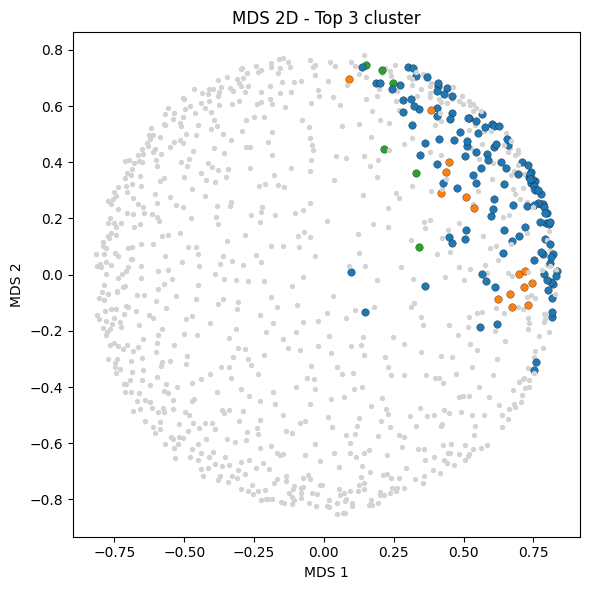

[INFO] Genero miniature per ciascun cluster di 'brain_glioma' …
[INFO] Cluster 5: 125 immagini trovate


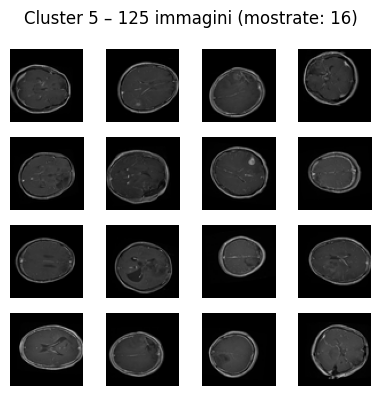

[INFO] Cluster 12: 15 immagini trovate


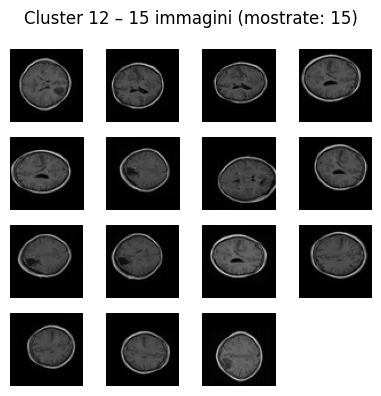

[INFO] Cluster 21: 6 immagini trovate


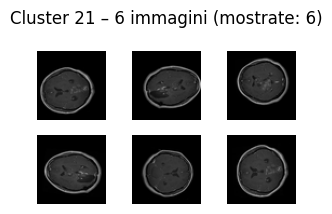


[INFO] Elaboro label: brain_menin
Applicazione di pca -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]
[INFO] Top 3 cluster (per dimensione): [0, 1, 4]
[INFO] Disegno MDS 2D per i cluster di 'brain_menin' …


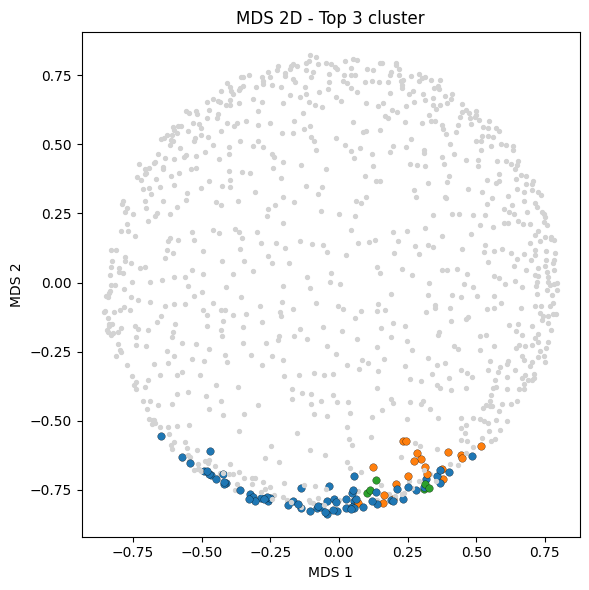

[INFO] Genero miniature per ciascun cluster di 'brain_menin' …
[INFO] Cluster 0: 68 immagini trovate


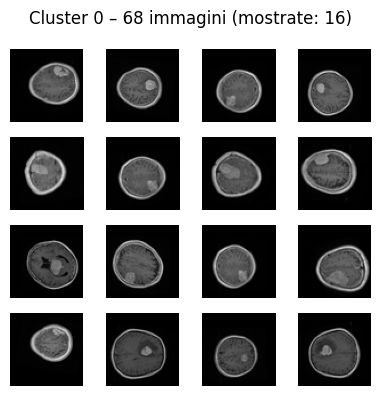

[INFO] Cluster 1: 20 immagini trovate


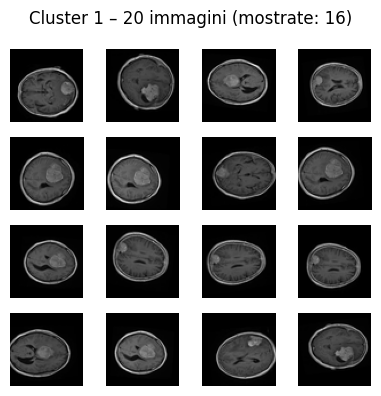

[INFO] Cluster 4: 6 immagini trovate


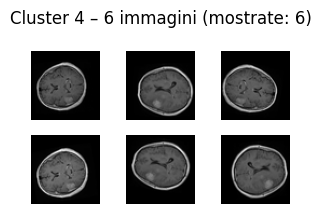


[INFO] Elaboro label: brain_tumor
Applicazione di pca -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1  2  3  4  5  6  7  8  9 10]
[INFO] Top 3 cluster (per dimensione): [5, 0, 1]
[INFO] Disegno MDS 2D per i cluster di 'brain_tumor' …


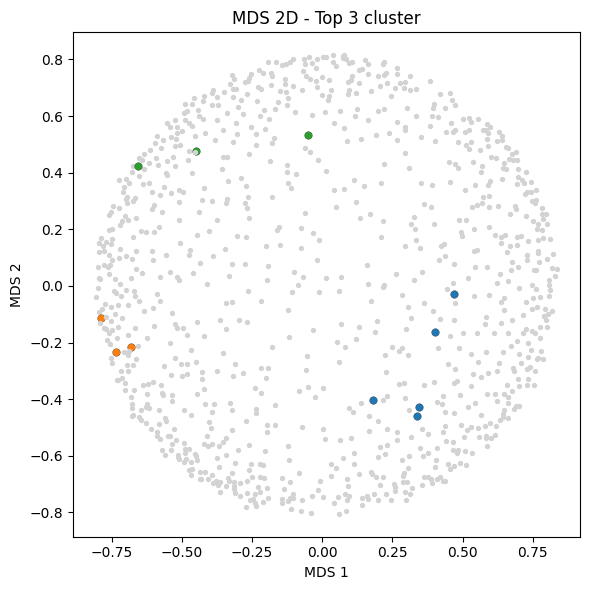

[INFO] Genero miniature per ciascun cluster di 'brain_tumor' …
[INFO] Cluster 5: 5 immagini trovate


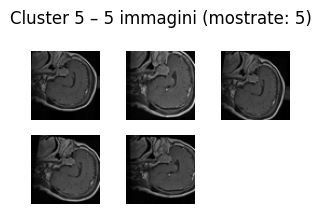

[INFO] Cluster 0: 3 immagini trovate


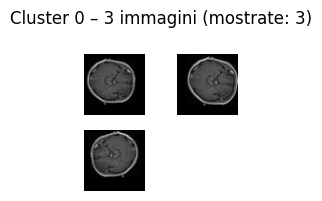

[INFO] Cluster 1: 3 immagini trovate


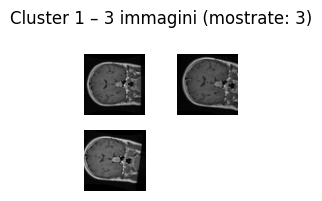


[FINITO] Task 8 completato per tutte le label di Parte1.


In [31]:
eps = 5.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label
method = 'pca'      # umap or pca
db_scan_detection(eps, min_samples, n_components, c, method)

# Task 9

Implementa un programma che, dati le immagini della parte 1:

*crea un classificatore m-NN (per una m specificata dall'utente),

*crea un classificatore ad albero decisionale,
Per questo task, puoi utilizzare lo spazio delle feature di tua scelta.    

Per le immagini della parte 2, prevede le etichette più probabili utilizzando il classificatore selezionato dall'utente.
Il sistema dovrebbe anche fornire valori di precisione, richiamo e punteggio F1 per etichetta, nonché un valore di accuratezza complessiva.    


In [38]:


# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))


Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.94      0.96      0.95      1002
 brain_menin       0.93      0.87      0.90      1002
 brain_tumor       0.91      0.95      0.93      1002

    accuracy                           0.93      3006
   macro avg       0.93      0.93      0.93      3006
weighted avg       0.93      0.93      0.93      3006

Accuratezza complessiva m-NN: 0.926480372588157
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.81      0.82      0.81      1002
 brain_menin       0.70      0.69      0.69      1002
 brain_tumor       0.76      0.76      0.76      1002

    accuracy                           0.76      3006
   macro avg       0.76      0.76      0.76      3006
weighted avg       0.76      0.76      0.76      3006

Accuratezza complessiva Decision Tree: 0.7561543579507651


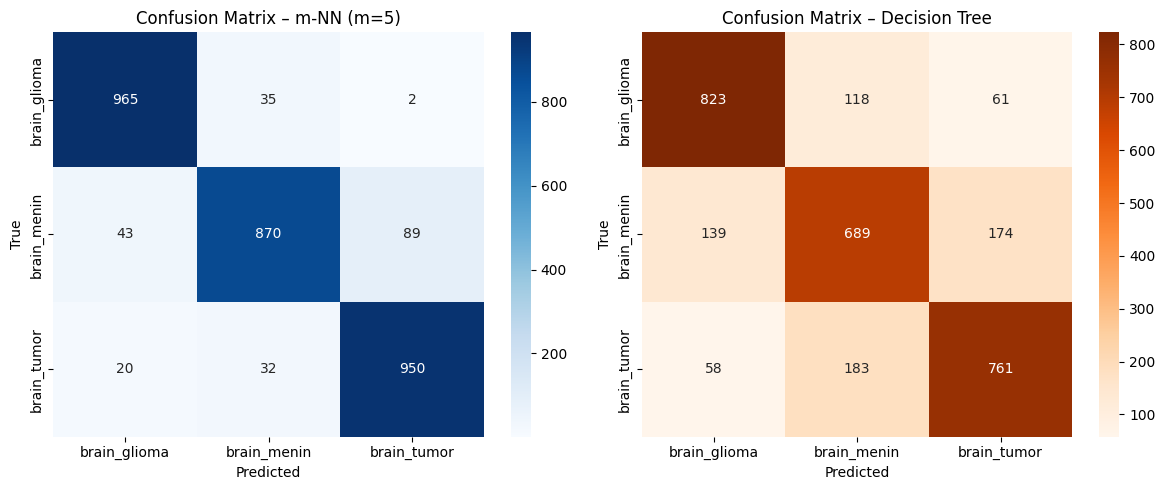

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ordine coerente delle classi
labels_order = np.unique(np.concatenate([lbls_part1, lbls_part2]))

# Calcolo delle confusion matrix
cm_knn = confusion_matrix(lbls_part2, pred_knn, labels=labels_order)
cm_dt  = confusion_matrix(lbls_part2, pred_dt,  labels=labels_order)

# Visualizzazione
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_knn, annot=True, fmt='d', ax=axs[0], cmap='Blues',
            xticklabels=labels_order, yticklabels=labels_order)
axs[0].set_title(f"Confusion Matrix – m-NN (m={m})")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_dt, annot=True, fmt='d', ax=axs[1], cmap='Oranges',
            xticklabels=labels_order, yticklabels=labels_order)
axs[1].set_title("Confusion Matrix – Decision Tree")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.show()


# Task 10

> 10a:

 Implementa uno strumento di Locality Sensitive Hashing (LSH) (per la distanza euclidea) che prende come input (a) il numero di livelli, L, (b) il numero di hash per livello, h, e (c) un insieme di vettori come input e crea una struttura di indice in memoria contenente l'insieme di vettori dato. 

Vedi:
"Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions" (di Alexandr Andoni e Piotr Indyk). Communications of the ACM, vol. 51, no. 1, 2008, pp. 117-122.    



In [44]:
# Classe LSH con quantizzazione

class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea (p-stable) con bucket width r.
    Ogni hash h_j(v) = floor((a_j · v + b_j) / r).

    Parametri:
      - num_layers   = L = numero di tavole hash
      - num_hashes   = h = numero di functions concatenati in ciascuna tavola
      - dim          = D = dimensione dei vettori di input
      - r            = bucket width (parte intera di quantizzazione)
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        # Prepara L tavole hash: ciascuna è un dict (chiave tuple di h interi -> lista di indici)
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]

        # Per ogni layer l=0..L-1, e per ogni j=0..h-1, genero:
        #   - a_lj  vettore gaussiano di dimensione D
        #   - b_lj  offset (uniforme in [0, r) )
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]

        # Memorizzerò i vettori originali di Part1 in questo array, shape=(N, D)
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        """
        Calcola l'hash (h interi) per il layer layer_idx su un vettore vec:
          h_j = floor((a_vectors[layer_idx][j] · vec + b_offsets[layer_idx][j]) / r)
        Ritorna una tupla di h interi.
        """
        keys = []
        a_vs = self.a_vectors[layer_idx]
        b_os = self.b_offsets[layer_idx]
        for j in range(self.h):
            a_j = a_vs[j]         # vettore dimensione D
            b_j = b_os[j]         # float in [0, r)
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            keys.append(h_val)
        return tuple(keys)

    def index(self, vectors: np.ndarray):
        """
        Costruisci l'indice LSH su un insieme di vettori di Part1:
          vectors: numpy array shape = (N, D)
        Al termine di questa chiamata:
          - self.data_vectors = vectors
          - self.hash_tables[l][hash_tuple] conterrà la lista di indici i per cui
            hash_tuple = _compute_hash_tuple(vectors[i], l).
        """
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Errore: dimensione vettore ({D}) ≠ atteso ({self.d})."

        # Inserisco ogni vettore in ciascuna tavola hash
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        """
        Esegui una query LSH per cercare i top_t vettori più vicini a q_vec.
        Restituisce:
          - top_results: lista di tuple (indice, distanza) ord. per dist. crescente
          - unique_count: numero di indici distinti considerati (cardinalità dei candidati)
          - total_checked: somma della lunghezza di tutti i bucket esaminati
        """
        assert q_vec.shape[0] == self.d, "Errore: dimensione query ≠ D."
        candidati = set()
        total_checked = 0

        # Per ciascun layer, ottengo la chiave polidimensionale e i suoi bucket
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        # Ora calcolo la distanza euclidea esatta tra q_vec e ciascun candidato
        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))

        # Ordino e prendo i primi top_t
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked
    def get_stats(self):
        """Restituisce statistiche sull'indice LSH con quantizzazione"""
        total_buckets = sum(len(table) for table in self.hash_tables)
        non_empty_buckets = sum(
            1 for table in self.hash_tables for bucket in table.values() if bucket
        )
        all_bucket_sizes = [len(bucket) for table in self.hash_tables for bucket in table.values() if bucket]

        return {
            'total_vectors': len(self.data_vectors),
            'layers': self.L,
            'hashes_per_layer': self.h,
            'total_buckets': total_buckets,
            'non_empty_buckets': non_empty_buckets,
            'avg_bucket_size': np.mean(all_bucket_sizes) if all_bucket_sizes else 0
        }


In [45]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
print("mean_vec.shape =", mean_vec.shape)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 7                        # numero di funzioni concatenati in ciascuna tavola
r = 1                      # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)
stats = lsh_quant.get_stats()
print("\n[STATISTICHE LSH-Quant]")
for k, v in stats.items():
    print(f"{k}: {v}")

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


mean_vec.shape = (1000,)

[STATISTICHE LSH-Quant]
total_vectors: 3006
layers: 10
hashes_per_layer: 7
total_buckets: 24577
non_empty_buckets: 24577
avg_bucket_size: 1.2230947633966718
[INFO] LSH quantizzato costruito: D=1000, L=10, h=7, r=1


> 10b:

 Implementa un algoritmo di ricerca di immagini simili utilizzando questa struttura di indice che memorizza le immagini della parte 1 e un modello visivo di tua scelta (il modello visivo combinato deve avere almeno 256 dimensioni): per una data immagine di query e un numero intero t, 
 
*visualizza le t immagini più simili,
*fornisce il numero di immagini univoche e il numero complessivo di immagini considerate durante il processo.    

In [42]:
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Trova le k immagini più simili a img_path (di Part2) usando lsh_quant costruito su Part1.
    """
    # 1) Estrai feature raw (900-dim)
    raw_q, _, _ = extract_fc_features(img_path, model, preprocess, device)
    raw_q = np.array(raw_q, dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec usato su Part1)
    print("raw_q.shape =", raw_q.shape)        # ad esempio (1024,)
    print("mean_vec.shape =", mean_vec.shape)  # ad esempio (900,) o (2048,) o altro
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampo i risultati testuali
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


Test

In [ ]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1410.jpg"

k = 3                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)
